# シミュレーションコード

- 並列化処理
- 機械語に変換
- 最短のコード

### ライブラリ

In [44]:
from pathlib import Path
import numpy as np
import pandas as pd
import re
from datetime import datetime
import gc
import numba as nb
import time


# 可視化
import geopandas as gpd
from shapely.geometry import box
import contextily as ctx
import shapely
import pyproj
from matplotlib import font_manager, rcParams
import matplotlib.pyplot as plt



FONT_PATH = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
font_prop = font_manager.FontProperties(fname=FONT_PATH)

rcParams["font.family"] = font_prop.get_name()

### データの読み込み

In [28]:
# 正解データ・同化データと遷移確率算出に使う期間を分けファイルをリスト化


BASE_DIR = Path("../../data/processed/yamada_processed/trans_count")

# =========================
# 期間指定（ここだけ変える）
# =========================
TRANS_START = "20190201"  # 遷移確率（学習/同化）に使う開始日
TRANS_END   = "20190213"  # 遷移確率（学習/同化）に使う終了日

GT_START = "20190214"     # 正解（評価）に使う開始日
GT_END   = "20190214"     # 正解（評価）に使う終了日


# =========================
# state_count_YYYYMMDD.csv を集める
# =========================
all_paths = sorted(BASE_DIR.glob("state_count_*.csv"))
print("all files:", len(all_paths))

date_re = re.compile(r"state_count_(\d{8})\.csv$")


# =========================
# 日付で分ける
# =========================
trans_paths = []
gt_paths = []
others = []

trans_start = datetime.strptime(TRANS_START, "%Y%m%d")
trans_end   = datetime.strptime(TRANS_END, "%Y%m%d")

gt_start = datetime.strptime(GT_START, "%Y%m%d")
gt_end   = datetime.strptime(GT_END, "%Y%m%d")

for p in all_paths:
    m = date_re.search(p.name)
    if not m:
        others.append(p)
        continue

    d = datetime.strptime(m.group(1), "%Y%m%d")

    if trans_start <= d <= trans_end:
        trans_paths.append(p)
    elif gt_start <= d <= gt_end:
        gt_paths.append(p)
    else:
        others.append(p)

print("\n【遷移確率（学習・同化）に使う期間】")
print("ファイル数:", len(trans_paths))
for p in trans_paths:
    print(p.name)

print("\n【正解（評価）に使う期間】")
print("ファイル数:", len(gt_paths))
for p in gt_paths:
    print(p.name)

all files: 14

【遷移確率（学習・同化）に使う期間】
ファイル数: 13
state_count_20190201.csv
state_count_20190202.csv
state_count_20190203.csv
state_count_20190204.csv
state_count_20190205.csv
state_count_20190206.csv
state_count_20190207.csv
state_count_20190208.csv
state_count_20190209.csv
state_count_20190210.csv
state_count_20190211.csv
state_count_20190212.csv
state_count_20190213.csv

【正解（評価）に使う期間】
ファイル数: 1
state_count_20190214.csv


### 遷移確率算出

In [31]:
# 遷移確率算出
df_list = []
for p in trans_paths:
    tmp = pd.read_csv(p)
    tmp["__source_file"] = p.name
    df_list.append(tmp)

trans_df = pd.concat(df_list, ignore_index=True)

print("【結合完了】行数:", len(trans_df))
print("カラム:", list(trans_df.columns))
trans_df.head()

trans_df["time_15min"] = pd.to_datetime(trans_df["time_15min"], errors="coerce")
trans_df = trans_df.dropna(subset=["time_15min"]).copy()

# 日付を無視して「時刻（HH:MM）」だけにする
trans_df["time_hm"] = trans_df["time_15min"].dt.strftime("%H:%M")

trans_df[["time_15min", "time_hm"]].head()

# 分母：ある time_hm, state_* にいる総遷移数
denom = (
    trans_df
    .groupby(["time_hm", "state_mesh", "state_poi"], as_index=False)
    .agg(total=("n_transition", "sum"))
)

# 分子：特定の next_* への遷移数（そのまま）
numer = (
    trans_df
    .groupby(["time_hm", "state_mesh", "state_poi", "next_mesh", "next_poi"], as_index=False)
    .agg(n_transition=("n_transition", "sum"))
)

# 遷移確率 p
transition_prob_df = numer.merge(
    denom, on=["time_hm", "state_mesh", "state_poi"], how="left"
)
transition_prob_df["p"] = transition_prob_df["n_transition"] / transition_prob_df["total"]

print("【遷移確率】shape:", transition_prob_df.shape)

def normalize_mesh_str(x) -> str:
    if pd.isna(x):
        return ""
    try:
        return str(int(float(x)))  # 11111111.0 -> "11111111"
    except Exception:
        return str(x).strip()

# mesh正規化
transition_prob_df["state_mesh"] = transition_prob_df["state_mesh"].apply(normalize_mesh_str)
transition_prob_df["next_mesh"]  = transition_prob_df["next_mesh"].apply(normalize_mesh_str)

# poi正規化（空白やNaN対策）
transition_prob_df["state_poi"] = transition_prob_df["state_poi"].astype(str).str.strip()
transition_prob_df["next_poi"]  = transition_prob_df["next_poi"].astype(str).str.strip()

# time正規化
transition_prob_df["time_hm"] = transition_prob_df["time_hm"].astype(str).str.zfill(5)

transition_prob_df.head()


【結合完了】行数: 370673
カラム: ['time_15min', 'state_mesh', 'state_poi', 'next_mesh', 'next_poi', 'n_transition', '__source_file']
【遷移確率】shape: (108519, 8)


,time_hm,state_mesh,state_poi,next_mesh,next_poi,n_transition,total,p
0,00:00,11111111,OoR,11111111,OoR,403,590,0.683051
1,00:00,11111111,OoR,53393464,home,1,590,0.001695
2,00:00,11111111,OoR,53393472,home,2,590,0.003390
3,00:00,11111111,OoR,53393472,move,4,590,0.006780
4,00:00,11111111,OoR,53393473,home,2,590,0.003390


### 正解の滞在人数作成

In [32]:
## 正解データの準備
df_list = []

for p in gt_paths:
    tmp = pd.read_csv(p)
    tmp["__source_file"] = p.name
    df_list.append(tmp)

print("正解データファイル",gt_paths)
gt_df = pd.concat(df_list, ignore_index=True)

print("【結合完了】行数:", len(gt_df))
print("カラム:", list(gt_df.columns))
gt_df.head()

# time_15min を datetime に
gt_df["time_15min"] = pd.to_datetime(gt_df["time_15min"], errors="coerce")
gt_df = gt_df.dropna(subset=["time_15min"]).copy()

# 日付を無視して時刻(HH:MM)だけにする（必要なら）
gt_df["time_hm"] = gt_df["time_15min"].dt.strftime("%H:%M")


# ✅ 各時刻 × 各メッシュ × 各PoI の滞在人数
gt_stay_df = (
    gt_df
    .groupby(["time_hm", "state_mesh", "state_poi"], as_index=False)
    .agg(n_people=("n_transition", "sum"))
)

# =========================
# ★追加：正規化（ここが重要）
# =========================
gt_stay_df["state_mesh"] = (
    gt_stay_df["state_mesh"]
    .astype(str)
    .str.replace(r"\.0$", "", regex=True)  # "53393472.0" -> "53393472"
)

gt_stay_df["state_poi"] = (
    gt_stay_df["state_poi"]
    .astype(str)
    .str.strip()
)

print("【滞在人数DF】shape:", gt_stay_df.shape)
display(gt_stay_df.head(20))


正解データファイル [PosixPath('../../data/processed/yamada_processed/trans_count/state_count_20190214.csv')]
【結合完了】行数: 28380
カラム: ['time_15min', 'state_mesh', 'state_poi', 'next_mesh', 'next_poi', 'n_transition', '__source_file']
【滞在人数DF】shape: (19552, 4)


,time_hm,state_mesh,state_poi,n_people
0,00:00,11111111,OoR,57
1,00:00,11111111,home,365
2,00:00,53393463,home,3
3,00:00,53393464,home,16
4,00:00,53393464,製造・加工,1
5,00:00,53393464,販売・卸,1
6,00:00,53393471,home,7
7,00:00,53393472,home,42
8,00:00,53393472,その他サービス,2
9,00:00,53393472,交通・運輸・倉庫,1


### Config(シミュレーションの設定値)

In [33]:
# =========================
# 設定
# =========================
BRANCH_SIZE = 10       # 1ステップで世界を何倍にするか
TOP_K = 3             # 毎時で残す世界の数
BASE_SEED = 1000

START_TIME = "06:00"
END_TIME_ASSIM = "17:00"   # hh:mm まで同化
EVAL_TIME = "18:00"        # hh:mm で予測・評価

DEBUG = False


### 時間グリッド生成（15分刻み）

In [34]:
# =========================
# 時刻グリッド（15分刻み）
# =========================
time_grid = pd.date_range("2019-02-01 06:00", "2019-02-01 18:00", freq="15min")
time_hm_list = [t.strftime("%H:%M") for t in time_grid]

print("✅ time steps example:", time_hm_list[:5], "...", time_hm_list[-5:])


✅ time steps example: ['06:00', '06:15', '06:30', '06:45', '07:00'] ... ['17:00', '17:15', '17:30', '17:45', '18:00']


### gt_dict作成（正解滞在分布：時刻→(mesh,poi)→人数）

In [35]:
# =========================
# 正解滞在分布（時刻ごと）を dict にする
# key: time_hm -> Series(index=(state_mesh,state_poi), value=n_people)
# =========================
gt_dict = {}

tmp_gt = gt_stay_df.copy()
tmp_gt["time_hm"] = tmp_gt["time_hm"].astype(str)
tmp_gt["state_mesh"] = tmp_gt["state_mesh"].astype(str)
tmp_gt["state_poi"]  = tmp_gt["state_poi"].astype(str)

for tm, g in tmp_gt.groupby("time_hm"):
    s = g.groupby(["state_mesh", "state_poi"])["n_people"].sum()
    gt_dict[tm] = s

print("✅ gt_dict keys example:", list(gt_dict.keys()))
print(gt_dict["06:00"].sort_values(ascending=False).head(20))



✅ gt_dict keys example: ['00:00', '00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30', '22:45', '23:00', '23:15', '23:30']
state_mesh  state_poi
11111111    home         452
            OoR          204
53393485    home          89
53393473   

### 合成人口データからエージェントを作成

In [36]:
# =========================
# 設定（パラメータ）
# =========================
RAW_PATH = Path("../../data/raw/population/2015_001_8_13208.csv")

MIN_AGE = 18

# 阪上加工で残る就業形態（あなたの検証から確定）
KEEP_EMPLOYMENT_TYPES = ["一般労働者", "短時間労働者", "臨時労働者"]

rename_dict = {
    "prefecture_code": "都道府県コード",
    "prefecture_name": "都道府県名",
    "city_code": "市区町村コード",
    "city_name": "市区町村名",
    "town_code": "町丁目コード",
    "town_name": "町丁目名",
    "latitude": "緯度",
    "longitude": "経度",
    "household_id": "世帯ID",
    "family_type_id": "世帯類型ID",
    "family_type": "世帯類型",
    "num_member": "世帯人数",
    "abnormal_household": "異常世帯フラグ",
    "person_id": "個人ID",
    "age": "年齢",
    "gender_id": "性別ID",
    "gender": "性別",
    "role_household_type_id": "世帯内役割ID",
    "role_household_type": "世帯内役割",
    "industry_type_id": "産業分類ID",
    "industry_type": "産業分類",
    "employment_type_id": "就業形態ID",
    "employment_type": "就業形態",
    "company_size_id": "企業規模ID",
    "company_size": "企業規模",
}

# =========================
# Step 1: raw 読み込み
# =========================
df_raw = pd.read_csv(RAW_PATH)

print("【raw】shape:", df_raw.shape)
print("【raw】age min/max:", df_raw["age"].min(), df_raw["age"].max())
print("【raw】employment_type unique:", df_raw["employment_type"].dropna().unique())

# =========================
# Step 2: 条件抽出（阪上と一致する加工）
#   - 年齢 >= 18
#   - 就業形態 ∈ {一般労働者, 短時間労働者, 臨時労働者}
# =========================
df_people = df_raw[
    (df_raw["age"] >= MIN_AGE) &
    (df_raw["employment_type"].isin(KEEP_EMPLOYMENT_TYPES))
].copy()

print("【processed】shape:", df_people.shape)
print("【processed】age min/max:", df_people["age"].min(), df_people["age"].max())
print("【processed】employment_type:", df_people["employment_type"].value_counts(dropna=False))

# =========================
# Step 3: 日本語列名に変換
# =========================
df_people = df_people.rename(columns=rename_dict)

print("人数:", len(df_people))
print("columns:", df_people.columns.tolist())

display(df_people.head(1))


【raw】shape: (214281, 25)
【raw】age min/max: 0 100
【raw】employment_type unique: ['短時間労働者' '一般労働者' '臨時労働者']
【processed】shape: (88849, 25)
【processed】age min/max: 18 100
【processed】employment_type: employment_type
一般労働者     66584
短時間労働者    21378
臨時労働者       887
Name: count, dtype: int64
人数: 88849
columns: ['都道府県コード', '都道府県名', '市区町村コード', '市区町村名', '町丁目コード', '町丁目名', '緯度', '経度', '世帯ID', '世帯類型ID', '世帯類型', '世帯人数', '異常世帯フラグ', '個人ID', '年齢', '性別ID', '性別', '世帯内役割ID', '世帯内役割', '産業分類ID', '産業分類', '就業形態ID', '就業形態', '企業規模ID', '企業規模']


,都道府県コード,都道府県名,市区町村コード,市区町村名,町丁目コード,町丁目名,緯度,経度,世帯ID,世帯類型ID,...,性別ID,性別,世帯内役割ID,世帯内役割,産業分類ID,産業分類,就業形態ID,就業形態,企業規模ID,企業規模
177,13,東京都,13208,調布市,13208003004,富士見町４丁目,35.662585,139.534513,18324823,0,...,0,男性,0,単独世帯（男性）,60.0,Ｆ 電気・ガス・熱供給・水道業,10.0,一般労働者,1000.0,1000人以上


In [37]:
# 初期配置　めっしゅID の作成

# =========================
# 0. 前提チェック
# =========================
need_cols = ["個人ID", "緯度", "経度"]
missing = [c for c in need_cols if c not in df_people.columns]
if missing:
    raise ValueError(f"df_people に必要な列がありません: {missing}")

print("df_people shape:", df_people.shape)
print("緯度欠損:", df_people["緯度"].isna().sum())
print("経度欠損:", df_people["経度"].isna().sum())

# =========================
# 1. 緯度経度を数値化
# =========================
df_people["緯度"] = pd.to_numeric(df_people["緯度"], errors="coerce")
df_people["経度"] = pd.to_numeric(df_people["経度"], errors="coerce")

# 欠損がある行は mesh を作れないので除外（必要なら残してもOK）
df_people = df_people.dropna(subset=["緯度", "経度"]).copy()

print("欠損除外後 shape:", df_people.shape)
print("緯度範囲:", df_people["緯度"].min(), "〜", df_people["緯度"].max())
print("経度範囲:", df_people["経度"].min(), "〜", df_people["経度"].max())

# =========================
# 2. 緯度経度 → 3次メッシュID（約1km）
# =========================
lat = df_people["緯度"].to_numpy()
lon = df_people["経度"].to_numpy()

# ---- 1次メッシュ（40分 × 1度）----
p = np.floor(lat * 1.5).astype(int)   # 緯度 (40分単位)
a = np.floor(lon - 100).astype(int)   # 経度 (1度単位)
mesh1 = p * 100 + a

# ---- 2次メッシュ（5分 × 7.5分）----
q = np.floor((lat * 1.5 - p) * 8).astype(int)
b = np.floor(((lon - 100) - a) * 8).astype(int)
mesh2 = mesh1 * 100 + q * 10 + b

# ---- 3次メッシュ（30秒 × 45秒）----
r = np.floor(((lat * 1.5 - p) * 8 - q) * 10).astype(int)
c = np.floor((((lon - 100) - a) * 8 - b) * 10).astype(int)
mesh3 = mesh2 * 100 + r * 10 + c

# 追加（文字列が扱いやすい。数値でもOK）
df_people["mesh_level3"] = mesh3.astype(str)

print("\n✅ mesh_level3 付与完了")
print("mesh_level3 欠損:", df_people["mesh_level3"].isna().sum())
print("mesh_level3 ユニーク数:", df_people["mesh_level3"].nunique())

display(df_people[["個人ID", "緯度", "経度", "mesh_level3"]].head(10))


df_people shape: (88849, 25)
緯度欠損: 0
経度欠損: 0
欠損除外後 shape: (88849, 25)
緯度範囲: 35.636517262871074 〜 35.683031656739075
経度範囲: 139.51738976505803 〜 139.59321140606346

✅ mesh_level3 付与完了
mesh_level3 欠損: 0
mesh_level3 ユニーク数: 36


,個人ID,緯度,経度,mesh_level3
177,40952264,35.662585,139.534513,53393492
181,40952268,35.639386,139.549963,53393463
187,40952274,35.649432,139.534088,53393472
188,40952275,35.652872,139.530387,53393482
189,40952276,35.663240,139.522585,53393491
191,40952278,35.653308,139.566247,53393485
202,40952289,35.675722,139.562320,53394414
203,40952290,35.652266,139.547767,53393483
204,40952291,35.648511,139.541675,53393473
213,40952300,35.654103,139.556280,53393484


### mesh/poi をID化（str禁止で高速化）

In [38]:
# =========================
# mesh / poi を ID化
# =========================
# mesh候補（初期 + 遷移 + GT）から全集合を作る
all_mesh = pd.concat([
    df_people["mesh_level3"].astype(str),
    transition_prob_df["state_mesh"].astype(str),
    transition_prob_df["next_mesh"].astype(str),
    gt_stay_df["state_mesh"].astype(str),
], ignore_index=True).dropna().unique()

mesh2id = {m:i for i,m in enumerate(sorted(all_mesh))}
id2mesh = {i:m for m,i in mesh2id.items()}

# poi候補
all_poi = pd.concat([
    transition_prob_df["state_poi"].astype(str),
    transition_prob_df["next_poi"].astype(str),
    gt_stay_df["state_poi"].astype(str),
], ignore_index=True).dropna().unique()

poi2id = {p:i for i,p in enumerate(sorted(all_poi))}
id2poi = {i:p for p,i in poi2id.items()}

N_POI = len(poi2id)

print("✅ mesh vocab:", len(mesh2id))
print("✅ poi vocab :", len(poi2id))


✅ mesh vocab: 40
✅ poi vocab : 20


### 遷移テーブルをCSR形式に変換（Numba最適化）

In [39]:
# =========================
# CSR化（Numba安全：全部数値dtype）
# =========================
tmp = transition_prob_df.copy()
tmp["time_hm"] = tmp["time_hm"].astype(str)

tmp["state_mesh_id"] = tmp["state_mesh"].astype(str).map(mesh2id).astype(np.int32)
tmp["next_mesh_id"]  = tmp["next_mesh"].astype(str).map(mesh2id).astype(np.int32)
tmp["state_poi_id"]  = tmp["state_poi"].astype(str).map(poi2id).astype(np.int16)
tmp["next_poi_id"]   = tmp["next_poi"].astype(str).map(poi2id).astype(np.int16)
tmp["p"]             = tmp["p"].astype(np.float32)

STATE_SIZE = np.int64(len(mesh2id) * N_POI)

csr_by_time = {}

for t, g in tmp.groupby("time_hm"):
    # sid: int64
    sid = (g["state_mesh_id"].to_numpy(np.int64) * np.int64(N_POI) + g["state_poi_id"].to_numpy(np.int64)).astype(np.int64)

    order = np.argsort(sid)
    sid_sorted = sid[order].astype(np.int64)

    nm_sorted  = g["next_mesh_id"].to_numpy(np.int32)[order].astype(np.int32)
    np_sorted  = g["next_poi_id"].to_numpy(np.int16)[order].astype(np.int16)
    pr_sorted  = g["p"].to_numpy(np.float32)[order].astype(np.float32)

    # offset: int64
    offset = np.zeros(STATE_SIZE + 1, dtype=np.int64)
    counts = np.bincount(sid_sorted, minlength=int(STATE_SIZE)).astype(np.int64)
    offset[1:] = np.cumsum(counts)

    # 候補内正規化
    uniq = np.unique(sid_sorted)
    for s in uniq:
        st, ed = offset[s], offset[s + 1]
        ss = pr_sorted[st:ed].sum()
        if ss > 0:
            pr_sorted[st:ed] /= ss

    csr_by_time[t] = (offset, nm_sorted, np_sorted, pr_sorted)

print("✅ csr_by_time entries:", len(csr_by_time))
k = next(iter(csr_by_time.keys()))
off, nm, np_, pr = csr_by_time[k]
print("offset dtype:", off.dtype, "nm dtype:", nm.dtype, "np dtype:", np_.dtype, "pr dtype:", pr.dtype)


✅ csr_by_time entries: 95
offset dtype: int64 nm dtype: int32 np dtype: int16 pr dtype: float32


### 初期worldsの作成


In [40]:
# =========================
# 初期world（world=1固定）
# =========================
init_df = df_people[["個人ID", "mesh_level3"]].copy()
init_df = init_df.rename(columns={"個人ID": "agent_id", "mesh_level3": "initial_mesh"}).reset_index(drop=True)

A = len(init_df)
mesh0 = init_df["initial_mesh"].astype(str).map(mesh2id).astype(np.int32).to_numpy()

# 初期poiは gt(START_TIME) の分布からサンプル（あなたの設計踏襲）
TIME_HM = START_TIME
gt_0600 = gt_stay_df[gt_stay_df["time_hm"] == TIME_HM].copy()

poi_prob = gt_0600.groupby("state_poi")["n_people"].sum()
poi_prob = poi_prob / poi_prob.sum()

poi_labels = poi_prob.index.to_numpy()
poi_probs  = poi_prob.to_numpy()

rng_init = np.random.default_rng(777)
poi0_str = rng_init.choice(poi_labels, size=A, p=poi_probs)

poi0 = pd.Series(poi0_str).map(poi2id).astype(np.int16).to_numpy()

# ✅ W×A の2D配列（W=1）
mesh_W = mesh0.reshape(1, -1)
poi_W  = poi0.reshape(1, -1)

print("✅ init worlds:", mesh_W.shape[0], "agents/world:", mesh_W.shape[1])


✅ init worlds: 1 agents/world: 88849


In [41]:
@nb.njit
def _sample_cat_from_u(u, probs):
    s = 0.0
    for i in range(probs.shape[0]):
        s += probs[i]
        if u < s:
            return i
    return probs.shape[0] - 1


@nb.njit(parallel=True)
def expand_worlds_prange_seeded(mesh_W, poi_W, offset, nm, np_, pr, N_POI, base_seed, step_i, BR):
    """
    ✅ world方向 prange 並列
    ✅ 各エージェントに遷移確率を当ててサンプル（意味維持）
    ✅ RandomState禁止なので np.random.seed + np.random.random を使う
    """
    W, A = mesh_W.shape
    W2 = W * BR

    out_mesh = np.empty((W2, A), dtype=np.int32)
    out_poi  = np.empty((W2, A), dtype=np.int16)

    for w_idx in nb.prange(W):
        mesh0 = mesh_W[w_idx]
        poi0  = poi_W[w_idx]

        for b in range(BR):
            out_idx = w_idx * BR + b

            # ✅ seed固定（再現性担保）
            seed = base_seed + step_i * 100000 + out_idx * 13131
            np.random.seed(seed)

            m2 = mesh0.copy()
            p2 = poi0.copy()

            for j in range(A):
                sid = m2[j] * N_POI + p2[j]
                st = offset[sid]
                ed = offset[sid + 1]
                if st == ed:
                    continue

                # ✅ RandomState の代わり
                u = np.random.random()
                k = _sample_cat_from_u(u, pr[st:ed])

                m2[j] = nm[st + k]
                p2[j] = np_[st + k]

            out_mesh[out_idx] = m2
            out_poi[out_idx]  = p2

    return out_mesh, out_poi


print("✅ Numba kernel ready (RandomState removed)")


def expand_worlds(mesh_W, poi_W, t, step_i, BRANCH_SIZE, BASE_SEED):
    """
    csr_by_time を使って高速expand
    """
    if t not in csr_by_time:
        # 遷移が無い場合は複製
        return np.repeat(mesh_W, BRANCH_SIZE, axis=0), np.repeat(poi_W, BRANCH_SIZE, axis=0)

    offset, nm, np_, pr = csr_by_time[t]
    return expand_worlds_prange_seeded(
        mesh_W, poi_W,
        offset, nm, np_, pr,
        N_POI, BASE_SEED, step_i, BRANCH_SIZE
    )

print("✅ expand_worlds ready")


✅ Numba kernel ready (RandomState removed)
✅ expand_worlds ready


### 評価関数

In [42]:
def cosine_sim_from_series(pred_s: pd.Series, gt_s: pd.Series) -> float:
    # pred/gt を同じindex空間に揃える（unionを使わない）
    df = pd.concat(
        [
            pred_s.rename("pred"),
            gt_s.rename("gt"),
        ],
        axis=1
    ).fillna(0.0)

    x = df["pred"].to_numpy(dtype=float)
    y = df["gt"].to_numpy(dtype=float)

    nx = np.linalg.norm(x)
    ny = np.linalg.norm(y)

    if nx == 0 or ny == 0:
        return 0.0

    return float(np.dot(x, y) / (nx * ny))

### 同化ループ（ログあり、:00剪定あり）

In [ ]:
# =========================
# 同化ループ（Numba expand + 毎時剪定）
# =========================
log_rows = []

def _should_print_step(t_next: str) -> bool:
    return True  # 好きに調整（:00だけにするなら t_next.endswith(":00") など）

print(f"🚀 START assimilation: {START_TIME} -> {END_TIME_ASSIM}")
print(f"INIT worlds={mesh_W.shape[0]}, agents/world={mesh_W.shape[1]}, BRANCH_SIZE={BRANCH_SIZE}, TOP_K={TOP_K}")

# ✅ 計測開始
t0 = time.perf_counter()


for i in range(len(time_hm_list) - 1):
    t = time_hm_list[i]
    t_next = time_hm_list[i + 1]

    if t < START_TIME:
        continue
    if t >= END_TIME_ASSIM:
        break

    if _should_print_step(t_next):
        print(f"⏱ {t} -> {t_next} | worlds(before)={mesh_W.shape[0]}")

    # Step A: expand（ここが爆速化される）
    mesh_W, poi_W = expand_worlds(mesh_W, poi_W, t, i, BRANCH_SIZE, BASE_SEED)

    if _should_print_step(t_next):
        print(f"   ↳ worlds(after expand)={mesh_W.shape[0]}")

    # Step B: prune（:00）
    if t_next.endswith(":00"):
        if t_next not in gt_dict:
            print(f"[warn] {t_next} 正解が無いので剪定スキップ")
            continue

        gt_s = gt_dict[t_next]
        scores = []

        # worldごとにcosine（ここはまだpandasでもOK）
        for wid in range(mesh_W.shape[0]):
            pred_s = (
                pd.DataFrame({"mesh": mesh_W[wid], "poi": poi_W[wid]})
                .groupby(["mesh", "poi"])
                .size()
            )
            # gt側もIDに合わせる必要があるので、gt_sをmesh/poi IDに変換
            gt_df = gt_s.reset_index()
            gt_df["mesh"] = gt_df["state_mesh"].astype(str).map(mesh2id)
            gt_df["poi"]  = gt_df["state_poi"].astype(str).map(poi2id)
            gt_id_s = gt_df.groupby(["mesh", "poi"])["n_people"].sum()

            score = cosine_sim_from_series(pred_s, gt_id_s)
            scores.append((wid, score))

        scores.sort(key=lambda x: x[1], reverse=True)
        top_scores = scores[:TOP_K]

        keep_ids = [wid for wid, _ in top_scores]
        mesh_W = mesh_W[keep_ids]
        poi_W  = poi_W[keep_ids]

        print(f"\n📌 [{t_next} prune] keep TOP_K={TOP_K}")
        for rank, (wid, sc) in enumerate(top_scores, 1):
            print(f"  rank{rank}: world={wid} cosine={sc:.6f}")
        print(f"  => worlds(after prune)={mesh_W.shape[0]}\n")

        log_rows.append({
            "time_hm": t_next,
            "n_worlds_after_prune": int(mesh_W.shape[0]),
            "best_cosine": float(top_scores[0][1]),
        })


# ✅ 計測終了
t1 = time.perf_counter()
elapsed = t1 - t0

mins = int(elapsed // 60)
secs = elapsed - mins * 60

print("✅ 同化完了")
print(f"残った世界数: {mesh_W.shape[0]}")
print(f"⏱ 実行時間: {mins}分 {secs:.2f}秒")


🚀 START assimilation: 06:00 -> 17:00
INIT worlds=3, agents/world=88849, BRANCH_SIZE=10, TOP_K=3
⏱ 06:00 -> 06:15 | worlds(before)=3
   ↳ worlds(after expand)=30
⏱ 06:15 -> 06:30 | worlds(before)=30
   ↳ worlds(after expand)=300
⏱ 06:30 -> 06:45 | worlds(before)=300
   ↳ worlds(after expand)=3000
⏱ 06:45 -> 07:00 | worlds(before)=3000
   ↳ worlds(after expand)=30000

📌 [07:00 prune] keep TOP_K=3
  rank1: world=5333 cosine=0.792262
  rank2: world=492 cosine=0.792165
  rank3: world=453 cosine=0.792131
  => worlds(after prune)=3

⏱ 07:00 -> 07:15 | worlds(before)=3
   ↳ worlds(after expand)=30
⏱ 07:15 -> 07:30 | worlds(before)=30
   ↳ worlds(after expand)=300
⏱ 07:30 -> 07:45 | worlds(before)=300
   ↳ worlds(after expand)=3000
⏱ 07:45 -> 08:00 | worlds(before)=3000
   ↳ worlds(after expand)=30000

📌 [08:00 prune] keep TOP_K=3
  rank1: world=4883 cosine=0.965836
  rank2: world=265 cosine=0.965828
  rank3: world=668 cosine=0.965793
  => worlds(after prune)=3

⏱ 08:00 -> 08:15 | worlds(before

### 評価（EVAL_TIME）＋ best_pred を作る

In [17]:
# =========================
# 評価（EVAL_TIME）
# =========================
if EVAL_TIME not in gt_dict:
    raise ValueError(f"{EVAL_TIME} の正解滞在分布が gt_dict にありません")

gt_s = gt_dict[EVAL_TIME]

# gtをID化
gt_df = gt_s.reset_index()
gt_df["mesh"] = gt_df["state_mesh"].astype(str).map(mesh2id)
gt_df["poi"]  = gt_df["state_poi"].astype(str).map(poi2id)
gt_id_s = gt_df.groupby(["mesh", "poi"])["n_people"].sum()

scores_ = []
for wid in range(mesh_W.shape[0]):
    pred_s = (
        pd.DataFrame({"mesh": mesh_W[wid], "poi": poi_W[wid]})
        .groupby(["mesh", "poi"])
        .size()
    )
    score = cosine_sim_from_series(pred_s, gt_id_s)
    scores_.append((wid, score))

scores_.sort(key=lambda x: x[1], reverse=True)

print("\n[TOP3]")
for rank, (wid, sc) in enumerate(scores_[:3], 1):
    print(f"  rank{rank}: world={wid} cosine={sc:.6f}")

best_id = scores_[0][0]

best_pred = (
    pd.DataFrame({"mesh": mesh_W[best_id], "poi": poi_W[best_id]})
    .groupby(["mesh", "poi"])
    .size()
    .reset_index(name="n_people_pred")
)

# 表示用にmesh/poiをstrに戻す（あなたの最終アウトプット）
best_pred["mesh"] = best_pred["mesh"].map(id2mesh)
best_pred["poi"]  = best_pred["poi"].map(id2poi)

display(best_pred.sort_values("n_people_pred", ascending=False))



[TOP3]
  rank1: world=1 cosine=0.992581
  rank2: world=0 cosine=0.992552
  rank3: world=2 cosine=0.992496


,mesh,poi,n_people_pred
0,11111111,OoR,34922
1,11111111,home,4533
191,53393483,move,2640
190,53393483,home,1670
171,53393482,home,1366
...,...,...,...
381,53393497,スポーツ・趣味娯楽・レジャー,1
383,53393497,交通・運輸・倉庫,1
396,53394402,医療・薬・保険衛生,1
399,53394402,自動車・オートバイ・自転車・ドライブ,1


### 評価の結果のビジュアライズ

In [18]:
print(gt_s.name)
print(gt_s.reset_index().columns)
display(gt_s.reset_index().head())


n_people
Index(['state_mesh', 'state_poi', 'n_people'], dtype='object')


,state_mesh,state_poi,n_people
0,11111111,OoR,1434
1,11111111,home,317
2,53393463,home,1
3,53393464,home,8
4,53393464,move,2


In [19]:
# =========================
# GT（実データ）もDataFrame化（修正版）
# =========================
gt_df = gt_s.reset_index()

# ✅ 人数列は n_people なので、それを n_people_gt に変更
gt_df = gt_df.rename(columns={"n_people": "n_people_gt"})

# ✅ カラム名を揃える（state_mesh/state_poi → mesh/poi）
if "state_mesh" in gt_df.columns:
    gt_df = gt_df.rename(columns={"state_mesh": "mesh"})
if "state_poi" in gt_df.columns:
    gt_df = gt_df.rename(columns={"state_poi": "poi"})

display(gt_df.sort_values("n_people_gt", ascending=False).head(20))


,mesh,poi,n_people_gt
0,11111111,OoR,1434
1,11111111,home,317
87,53393483,move,115
185,53393496,move,39
86,53393483,home,39
75,53393482,home,36
117,53393485,move,35
116,53393485,home,32
24,53393473,home,30
102,53393484,home,26


In [20]:
# =========================
# Pred と GT を結合
# =========================
merge_df = best_pred.merge(gt_df, on=["mesh", "poi"], how="outer")
merge_df["n_people_pred"] = merge_df["n_people_pred"].fillna(0)
merge_df["n_people_gt"]   = merge_df["n_people_gt"].fillna(0)
merge_df["diff"] = merge_df["n_people_pred"] - merge_df["n_people_gt"]

print("✅ merged shape:", merge_df.shape)
display(merge_df.sort_values("n_people_gt", ascending=False).head(20))


✅ merged shape: (525, 5)


,mesh,poi,n_people_pred,n_people_gt,diff
0,11111111,OoR,34922.0,1434.0,33488.0
1,11111111,home,4533.0,317.0,4216.0
192,53393483,move,2640.0,115.0,2525.0
363,53393496,move,942.0,39.0,903.0
191,53393483,home,1670.0,39.0,1631.0
172,53393482,home,1366.0,36.0,1330.0
228,53393485,move,737.0,35.0,702.0
227,53393485,home,1309.0,32.0,1277.0
79,53393473,home,1240.0,30.0,1210.0
209,53393484,home,1223.0,26.0,1197.0


In [21]:
# =========================
# mesh単位に集約（poi無視して合計）
# =========================
mesh_map_df = (
    merge_df.groupby("mesh", as_index=False)
    .agg(
        n_pred=("n_people_pred", "sum"),
        n_gt=("n_people_gt", "sum"),
        diff=("diff", "sum"),
    )
)

display(mesh_map_df.sort_values("n_gt", ascending=False).head(20))


,mesh,n_pred,n_gt,diff
0,11111111,39455.0,1751.0,37704.0
14,53393483,7692.0,257.0,7435.0
16,53393485,3350.0,94.0,3256.0
24,53393496,2998.0,88.0,2910.0
15,53393484,3262.0,77.0,3185.0
7,53393473,3046.0,73.0,2973.0
13,53393482,3064.0,68.0,2996.0
8,53393474,2639.0,62.0,2577.0
6,53393472,1937.0,51.0,1886.0
23,53393495,1989.0,45.0,1944.0


In [22]:
# =========================
# 第3次メッシュ(8桁) -> 緯度経度BBox (minlon,minlat,maxlon,maxlat)
# =========================
def mesh3_to_bbox(mesh8: str):
    """
    JIS X 0410 第3次地域メッシュ(8桁) -> bbox
    return: (minlon, minlat, maxlon, maxlat)
    """
    m = str(mesh8)
    if len(m) != 8 or not m.isdigit():
        raise ValueError(f"invalid mesh code: {mesh8}")

    p = int(m[0:2])       # 緯度1次
    u = int(m[2:4])       # 経度1次
    q = int(m[4])         # 2次(緯度)
    v = int(m[5])         # 2次(経度)
    r = int(m[6])         # 3次(緯度)
    w = int(m[7])         # 3次(経度)

    # 1次メッシュ南西
    lat0 = p / 1.5
    lon0 = u + 100

    # 2次メッシュ(1次を8分割)
    lat0 += q * (5/60)
    lon0 += v * (7.5/60)

    # 3次メッシュ(2次を10分割)
    lat0 += r * (0.5/60)
    lon0 += w * (0.75/60)

    # 第3次のサイズ
    dlat = 0.5/60
    dlon = 0.75/60

    return (lon0, lat0, lon0 + dlon, lat0 + dlat)


In [23]:
# =========================
# 異常メッシュ除外（東京近辺だけ残す）
# =========================
# bbox中心でフィルタする
def bbox_center(mesh8):
    minlon, minlat, maxlon, maxlat = mesh3_to_bbox(mesh8)
    return ( (minlon+maxlon)/2, (minlat+maxlat)/2 )

centers = mesh_map_df["mesh"].astype(str).apply(bbox_center)
mesh_map_df["lon_c"] = centers.apply(lambda x: x[0])
mesh_map_df["lat_c"] = centers.apply(lambda x: x[1])

# ✅ 東京らへんだけ残す（必要なら調整）
mesh_map_df_tokyo = mesh_map_df[
    (mesh_map_df["lon_c"] >= 138.5) & (mesh_map_df["lon_c"] <= 141.5) &
    (mesh_map_df["lat_c"] >= 34.5)  & (mesh_map_df["lat_c"] <= 36.5)
].copy()

print("before:", len(mesh_map_df), "after:", len(mesh_map_df_tokyo))
display(mesh_map_df_tokyo.head())


before: 40 after: 39


,mesh,n_pred,n_gt,diff,lon_c,lat_c
1,53393462,2.0,0.0,2.0,139.53125,35.637500
2,53393463,276.0,1.0,275.0,139.54375,35.637500
3,53393464,1543.0,18.0,1525.0,139.55625,35.637500
4,53393465,88.0,0.0,88.0,139.56875,35.637500
5,53393471,193.0,6.0,187.0,139.51875,35.645833


In [24]:
polys = []
for mesh in mesh_map_df_tokyo["mesh"].astype(str):
    minlon, minlat, maxlon, maxlat = mesh3_to_bbox(mesh)
    polys.append(box(minlon, minlat, maxlon, maxlat))

gdf_tokyo = gpd.GeoDataFrame(mesh_map_df_tokyo, geometry=polys, crs="EPSG:4326")
print("✅ gdf_tokyo shape:", gdf_tokyo.shape)


✅ gdf_tokyo shape: (39, 7)


### 各メッシュの滞在人数で比較

vmax(pred/gt) = 7692.0
absmax(diff)  = 7435.0


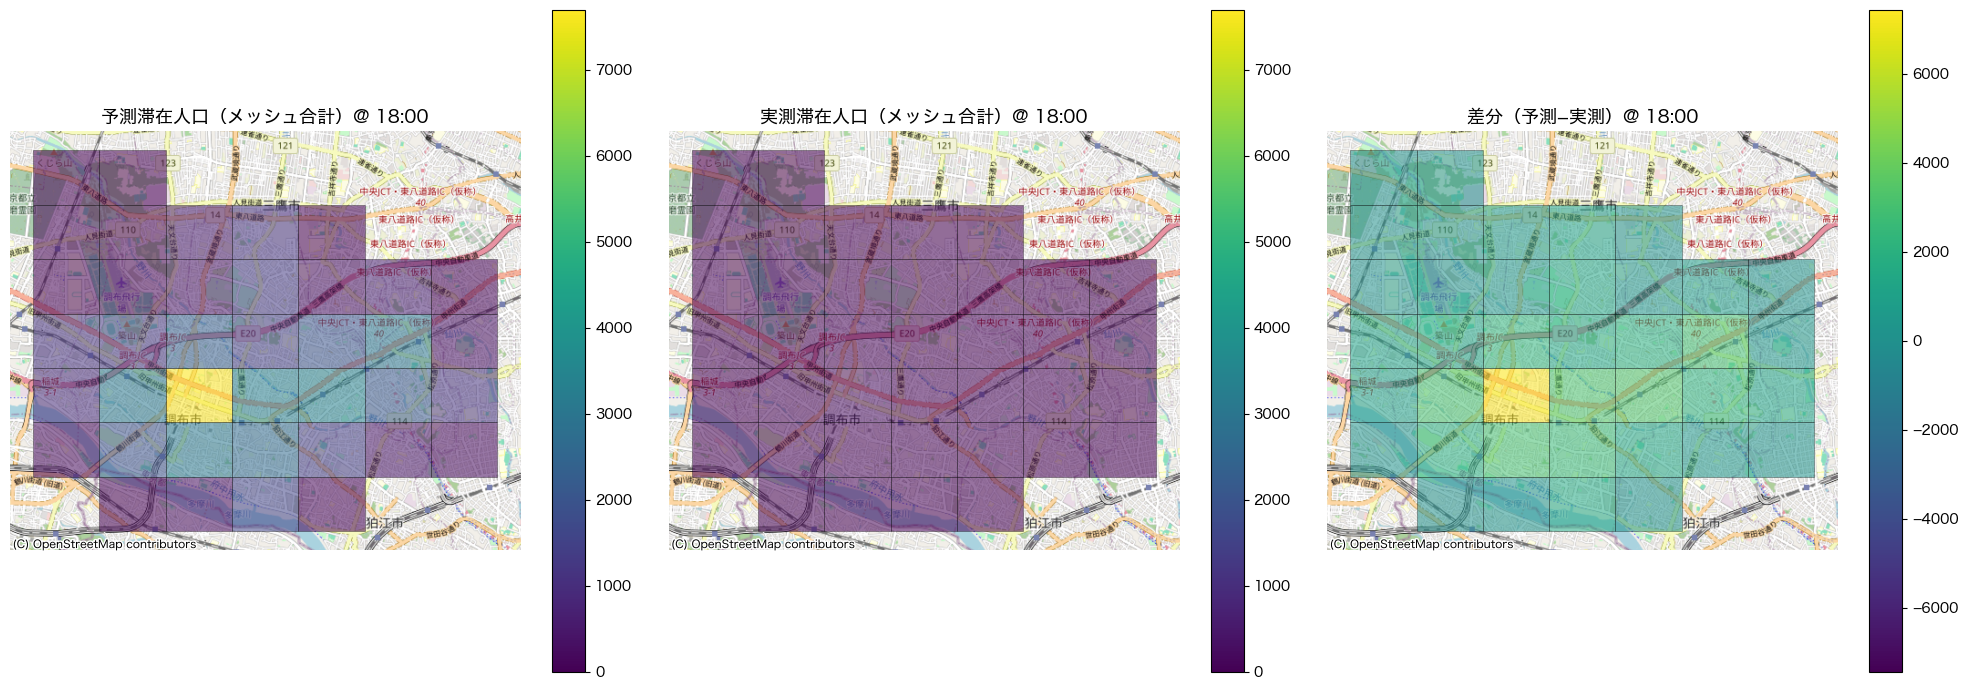

In [25]:
# =========================
# WebMercator に変換
# =========================
gdf_web = gdf_tokyo.to_crs(epsg=3857)

# =========================
# ✅ カラースケール統一値を計算
# =========================
vmax_pg = float(max(gdf_web["n_pred"].max(), gdf_web["n_gt"].max()))
absmax_diff = float(max(abs(gdf_web["diff"].min()), abs(gdf_web["diff"].max())))

print("vmax(pred/gt) =", vmax_pg)
print("absmax(diff)  =", absmax_diff)

# =========================
# 可視化（3枚）スケール統一
# =========================
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# --- 予測 ---
gdf_web.plot(
    column="n_pred",
    ax=axes[0],
    legend=True,
    vmin=0, vmax=vmax_pg,          # ✅ pred/gtで統一
    edgecolor="black", linewidth=0.4,
    alpha=0.55
)
axes[0].set_title(f"予測滞在人口（メッシュ合計）@ {EVAL_TIME}", fontsize=13)

# --- 実測 ---
gdf_web.plot(
    column="n_gt",
    ax=axes[1],
    legend=True,
    vmin=0, vmax=vmax_pg,          # ✅ pred/gtで統一
    edgecolor="black", linewidth=0.4,
    alpha=0.55
)
axes[1].set_title(f"実測滞在人口（メッシュ合計）@ {EVAL_TIME}", fontsize=13)

# --- 差分 ---
gdf_web.plot(
    column="diff",
    ax=axes[2],
    legend=True,
    vmin=-absmax_diff, vmax=absmax_diff,  # ✅ diffは左右対称
    edgecolor="black", linewidth=0.4,
    alpha=0.55
)
axes[2].set_title(f"差分（予測−実測）@ {EVAL_TIME}", fontsize=13)

# 背景地図
for ax in axes:
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()

plt.tight_layout()
plt.show()


### 比率で比較

In [26]:
# =========================
# share（比率）に変換
# =========================
sum_pred = float(gdf_web["n_pred"].sum())
sum_gt   = float(gdf_web["n_gt"].sum())

# ゼロ割り対策（全メッシュ0のケース）
if sum_pred == 0 or sum_gt == 0:
    raise ValueError(f"sum_pred={sum_pred}, sum_gt={sum_gt} のため正規化できない")

gdf_web["share_pred"] = gdf_web["n_pred"] / sum_pred
gdf_web["share_gt"]   = gdf_web["n_gt"]   / sum_gt

# 差分：シェア差（予測−実測）  ※単位は「割合」（= 0.01 で1%ポイント）
gdf_web["share_diff"] = gdf_web["share_pred"] - gdf_web["share_gt"]


vmax(share)      = 0.21909633418584826
absmax(share_diff) = 0.06336891790046947


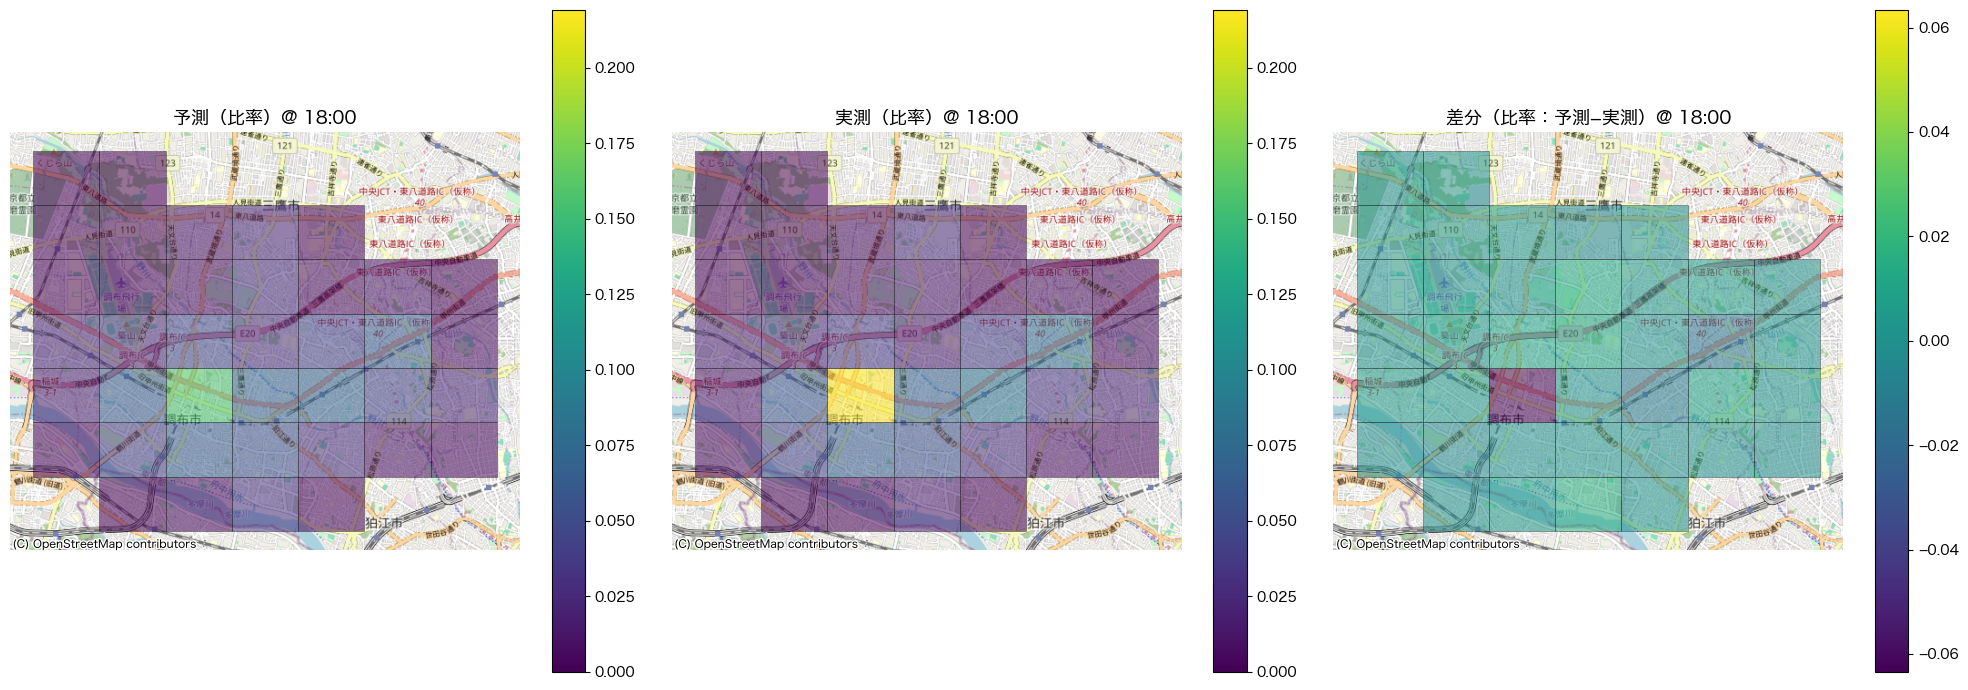

In [27]:
# =========================
# カラースケール統一値（share）
# =========================
vmax_share = float(max(gdf_web["share_pred"].max(), gdf_web["share_gt"].max()))
absmax_sdiff = float(max(abs(gdf_web["share_diff"].min()), abs(gdf_web["share_diff"].max())))

print("vmax(share)      =", vmax_share)
print("absmax(share_diff) =", absmax_sdiff)

# =========================
# 可視化（3枚）
# =========================
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# --- 予測 share ---
gdf_web.plot(
    column="share_pred",
    ax=axes[0],
    legend=True,
    vmin=0, vmax=vmax_share,
    edgecolor="black", linewidth=0.4,
    alpha=0.55
)
axes[0].set_title(f"予測（比率）@ {EVAL_TIME}", fontsize=13)

# --- 実測 share ---
gdf_web.plot(
    column="share_gt",
    ax=axes[1],
    legend=True,
    vmin=0, vmax=vmax_share,
    edgecolor="black", linewidth=0.4,
    alpha=0.55
)
axes[1].set_title(f"実測（比率）@ {EVAL_TIME}", fontsize=13)

# --- 差分 share ---
gdf_web.plot(
    column="share_diff",
    ax=axes[2],
    legend=True,
    vmin=-absmax_sdiff, vmax=absmax_sdiff,
    edgecolor="black", linewidth=0.4,
    alpha=0.55
)
axes[2].set_title(f"差分（比率：予測−実測）@ {EVAL_TIME}", fontsize=13)

for ax in axes:
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()

plt.tight_layout()
plt.show()
